In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config

In [2]:
np.random.seed(42)
set_config(display='diagram')

In [3]:
# additional setup of the tools
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_theme(style="whitegrid")

In [4]:
trainDf = pd.read_csv("data/train.csv")
testDf = pd.read_csv("data/test.csv")

In [5]:
# Remove outliers
trainDf.drop(
    trainDf[(trainDf["GrLivArea"] > 4000) & (trainDf["SalePrice"] < 700000)].index
);

In [6]:
def imputeDwellingGroup(dwellingInfo):
    dwellingType = dwellingInfo[0]
    dwellingSubclass = dwellingInfo[1]

    return dwellingType + '-' + str(dwellingSubclass)

trainDf['dwellingGroup'] = trainDf[['BldgType', 'MSSubClass']].apply(imputeDwellingGroup, axis=1)

In [7]:
baselineFeatures = ['GrLivArea', 'OverallQual', 'GarageCars', 'OverallCond', 'Neighborhood', 'MSSubClass'] # 'MSZoning'

X = trainDf[baselineFeatures]
Y = trainDf['SalePrice']

X

,GrLivArea,OverallQual,GarageCars,OverallCond,Neighborhood,MSSubClass
0,1710,7,2,5,CollgCr,60
1,1262,6,2,8,Veenker,20
2,1786,7,2,5,CollgCr,60
3,1717,7,3,5,Crawfor,70
4,2198,8,3,5,NoRidge,60
...,...,...,...,...,...,...
1455,1647,6,2,5,Gilbert,60
1456,2073,6,2,6,NWAmes,20
1457,2340,7,1,9,Crawfor,70
1458,1078,5,1,6,NAmes,20


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [9]:
# Build feature transformer

featureTransformer = ColumnTransformer([
        ('living_area_std_scale', StandardScaler(), ['GrLivArea']),
        ('neighborhood_onehot', OneHotEncoder(), ['Neighborhood']),
        ('house_subclass_onehot', OneHotEncoder(), ['MSSubClass']),
    ],
    remainder='passthrough'
)

featureTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('living_area_std_scale', StandardScaler(),
                                 ['GrLivArea']),
                                ('neighborhood_onehot', OneHotEncoder(),
                                 ['Neighborhood']),
                                ('house_subclass_onehot', OneHotEncoder(),
                                 ['MSSubClass'])])

In [10]:
# View of transformed training set

featureTransformer.fit(X_train)
featureTransformer.named_transformers_['neighborhood_onehot'].get_feature_names()

array(['x0_Blmngtn', 'x0_Blueste', 'x0_BrDale', 'x0_BrkSide',
       'x0_ClearCr', 'x0_CollgCr', 'x0_Crawfor', 'x0_Edwards',
       'x0_Gilbert', 'x0_IDOTRR', 'x0_MeadowV', 'x0_Mitchel', 'x0_NAmes',
       'x0_NPkVill', 'x0_NWAmes', 'x0_NoRidge', 'x0_NridgHt',
       'x0_OldTown', 'x0_SWISU', 'x0_Sawyer', 'x0_SawyerW', 'x0_Somerst',
       'x0_StoneBr', 'x0_Timber', 'x0_Veenker'], dtype=object)

In [11]:
# Initialize Regression Model
baselineModel = LinearRegression()

In [12]:
regressionPipeline = Pipeline([
    ("preprocessing", featureTransformer),
    ("regression", baselineModel)
])

In [13]:
regressionPipeline.fit(X_train, y_train)

y_train_predicted = regressionPipeline.predict(X_train)
y_test_predicted = regressionPipeline.predict(X_test)

In [14]:
## Metrics from Test Data
print('[Train] Mean Squared Error: %.2f' % mean_squared_error(y_train, y_train_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Train] Coefficient of Determination: %.2f' % r2_score(y_train, y_train_predicted))

[Train] Mean Squared Error: 1114470130.58
[Train] Coefficient of Determination: 0.81


In [15]:
## Metrics from Test Data
print('[Test] Mean Squared Error: %.2f' % mean_squared_error(y_test, y_test_predicted))
# The coefficient of determination: 1 is perfect prediction
print('[Test] Coefficient of Determination: %.2f' % r2_score(y_test, y_test_predicted))

[Test] Mean Squared Error: 1086791240.94
[Test] Coefficient of Determination: 0.84


In [16]:
def plot_regression_results(ax, y_true, y_pred, title):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    
    ax.set_title(title)

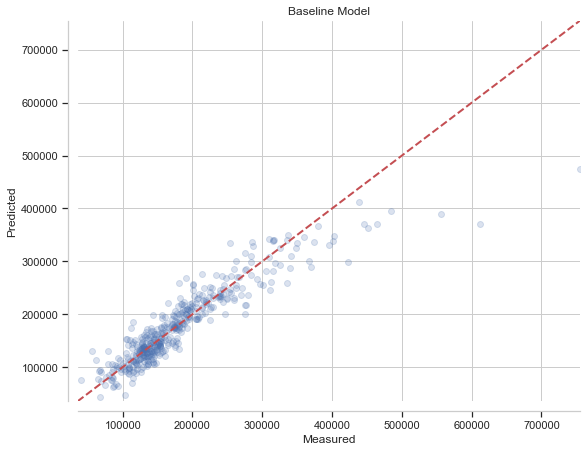

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7))

plot_regression_results(
    ax, 
    y_true=y_test, 
    y_pred=y_test_predicted, 
    title="Baseline Model"
)